## Exercício
Uma cavidade ressonante, ilustrada na figura abaixo, tem todas as paredes elétricas e é
preenchida com material FR-4 (&epsilon;<sub>r</sub> = 4,4 e tg&delta; = 0,02). As paredes são constituídas de
cobre com condutividade &sigma;=5,8x10<sup></sup> S/m.
Dados: A = B = 45,95 mm e h = 1,6 mm.

In [29]:
# Problem constants to be matched with the ones above

A = 45.95e-3
B = A
h = 1.6e-3

epsilon_r = 4.4
loss_tangent = 0.02
condutancy = 5.8e7

In [30]:
# General imports needed

import numpy as np
from scipy import constants
import matplotlib.pyplot as plt
from mpl_smithchart import SmithAxes

In [25]:
# Saving configuration (what great comment, isn't it?)

save = True

In [31]:
# Real world constants

c = constants.speed_of_light
pi = constants.pi
epsilon_0 = constants.epsilon_0
mu_0 = constants.mu_0

In [35]:
# Class representing a rectangular resonator
#
# todo: implement the field equations with SymPy and derive the results symbolically, like the fields of mode 'mnl'

class RectangularResonator(object):
    def __init__(self, x, y, z, epsilon_r, mu_r, loss_tangent, condutancy):
        self.x = x
        self.y = y
        self.z = z
        self.epsilon_r = epsilon_r
        self.mu_r = mu_r
        self.loss_tangent = loss_tangent
        self.condutancy = condutancy
        self.dimensions = self.sort_dimensions()
        self.dominant_mode = self.get_dominant_mode()

    def sort_dimensions(self):
        dimensions = [
            {'dimension': 'x', 'value': self.x},
            {'dimension': 'y', 'value': self.y},
            {'dimension': 'z', 'value': self.z},
        ]

        return sorted(dimensions, key=lambda obj: obj['value'])
    
    def k(self, m, n, l):
        return np.sqrt((m * pi / self.x)**2 + (n * pi / self.y)**2 + (l * pi / self.z)**2)

    def frequency(self, m, n, l):
        k = self.k(m, n, l)
        return (c * k)/(2*pi * np.sqrt(self.epsilon_r * self.mu_r))

    def get_dominant_mode(self):
        position_encoding = {
            'x': 0,
            'y': 1,
            'z': 2,
        }
        
        mode = [0, 0, 0]
        for i, dim in enumerate(self.dimensions):
            if i != 0:
                mode[position_encoding[dim['dimension']]] = 1
    
        f = self.frequency(*mode)

        return {'mode': mode, 'frequency': f, 'frequency_formated': self.format_e(f)}


    def format_e(self, n):
        a = '%E' % n
        return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]


In [4]:
# Exercício Lab 6

A = 45.95e-3
B = A
h = 1.6e-3

epsilon_r = 4.4
loss_tangent = 0.02
condutancy = 5.8e7

In [5]:
# a) 

resonator = RectangularResonator(A, B, h, epsilon_r, 1, loss_tangent, condutancy)
resonator.dominant_mode

# {'mode': [1, 1, 0],
# 'frequency': 2199347485.866347,
# 'frequency_formated': '2.199347E+09'}

{'mode': [1, 1, 0],
 'frequency': 2199347485.866347,
 'frequency_formated': '2.199347E+09'}

In [6]:
# c)

def get_quality_factor_dominant_mode(resonator):
    Qd = 1/resonator.loss_tangent
    
    delta = 1/np.sqrt(pi * resonator.dominant_mode['frequency'] * resonator.mu_r * mu_0 * resonator.condutancy)
    Qc_den = (resonator.x * resonator.y**3 + 2 * resonator.y**3 * resonator.z + resonator.x**3 * (resonator.y + 2 * resonator.z)) * delta
    Qc_num = resonator.x * resonator.y * (resonator.x**2 + resonator.y**2) * resonator.z
    Qc = Qc_num/Qc_den

    Q = 1/(1/Qd + 1/Qc)

    return Q

Q = get_quality_factor_dominant_mode(resonator)
Q # 47.75080091766975

47.75080091766975

In [7]:
# d)

R = 50
w0 = 2*pi * resonator.dominant_mode['frequency']
L = R / (w0 * Q)
C = 1 / (w0**2 * L)
L, C # (7.577319931103823e-11, 6.910937040629139e-11)

(7.577319931103823e-11, 6.910937040629139e-11)

In [8]:
# e)

def X_L(f, r = 0.65e-3):
    multiplier = f * mu_0 * h
    k0 = condutancy * np.sqrt(mu_0 * epsilon_0)
    X_L = 1j * multiplier * (np.log(2/(k0 * r * np.sqrt(epsilon_r))) - 0.57721)
    return X_L

f = resonator.dominant_mode['frequency']
X_L(f) # 36.95207135743512j

36.95207135743512j

In [9]:
# f)

# Approximation near w0

R = 50
f0 = resonator.dominant_mode['frequency']
w0 = f0 * (2*pi)
Q = get_quality_factor_dominant_mode(resonator)
L = R / (w0 * Q)
C = 1 / (w0**2 * L)

def calculate_Z_in_near_resonance(delta_w):
    Z_in_unloaded = R / (1 + 2j * Q * delta_w/w0)

    w = w0 + delta_w
    f = w / (2*pi)
    Z_in = X_L(f) + Z_in_unloaded

    return Z_in

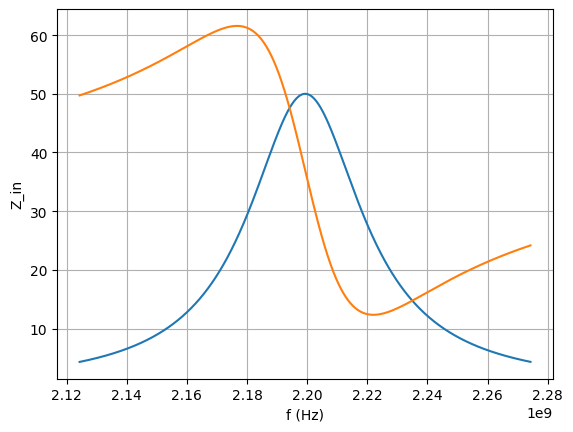

In [10]:
# Rectangular plot

delta_f = np.arange(-150e6/2, 150e6/2, 1e5)
delta_w = delta_f * (2*pi)
Z_in_near_resonance = calculate_Z_in_near_resonance(delta_w)

fig, ax = plt.subplots()
ax.plot(delta_f + f0, Z_in_near_resonance.real)
ax.plot(delta_f + f0, Z_in_near_resonance.imag)
ax.set(xlabel='f (Hz)', ylabel='Z_in')
ax.grid()


if save:
    plt.savefig("Z_in_near_resonance_rectangular.png")

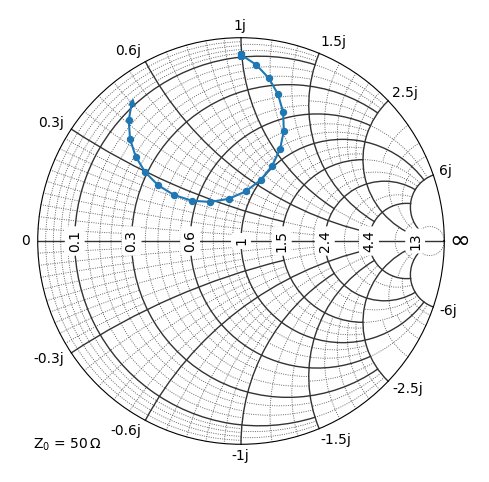

In [11]:
# Smith plot

plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1, projection='smith')
plt.plot(Z_in_near_resonance, equipoints=20, datatype=SmithAxes.Z_PARAMETER)

if save:
    plt.savefig("Z_in_near_resonance_smith.png")

In [12]:
# Exact value

R = 50
f0 = resonator.dominant_mode['frequency']
w0 = f0 * (2*pi)
Q = get_quality_factor_dominant_mode(resonator)
L = R / (w0 * Q)
C = 1 / (w0**2 * L)

def calculate_Z_in(w):
    Z_in_inv = (1/R + 1/(1j * w * L) + 1j * w * C)
    return 1/Z_in_inv

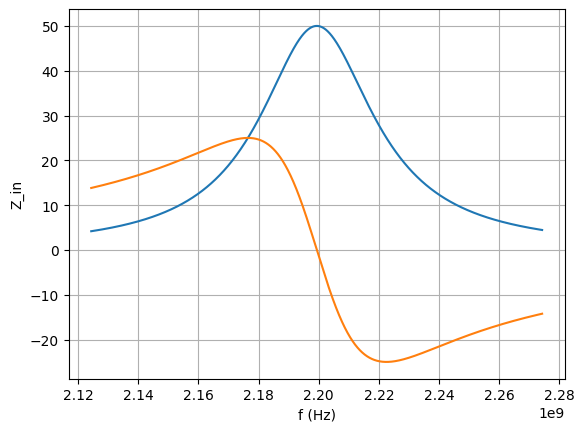

In [13]:
# Rectangular plot

f = np.arange(f0 - 150e6/2, f0 + 150e6/2, 1e5)
w = f * (2*pi)
Z_in = calculate_Z_in(w)

fig, ax = plt.subplots()
ax.plot(f, Z_in.real)
ax.plot(f, Z_in.imag)
ax.set(xlabel='f (Hz)', ylabel='Z_in')
ax.grid()


if save:
    plt.savefig("Z_in_rectangular.png")

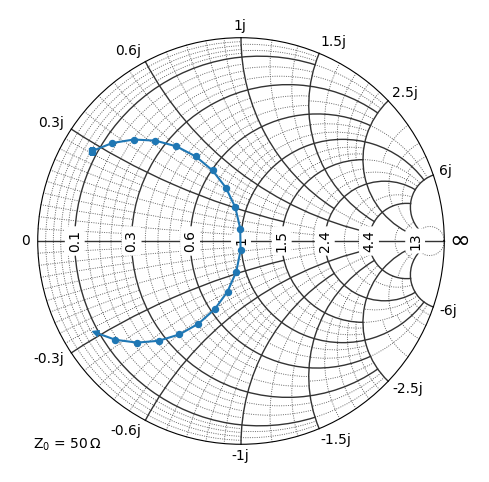

In [14]:
# Smith plot

plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1, projection='smith')
plt.plot(Z_in, equipoints=20, datatype=SmithAxes.Z_PARAMETER)

if save:
    plt.savefig("Z_in_smith.png")

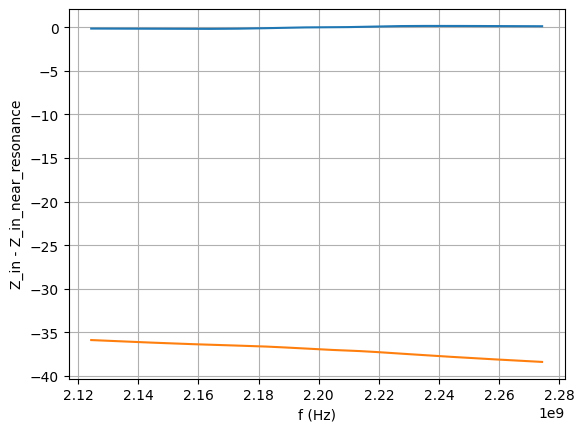

In [15]:
Z_in_diff = Z_in - Z_in_near_resonance

fig, ax = plt.subplots()
ax.plot(f, Z_in_diff.real)
ax.plot(f, Z_in_diff.imag)
ax.set(xlabel='f (Hz)', ylabel='Z_in - Z_in_near_resonance')
ax.grid()

if save:
    plt.savefig("Z_in_diff.png")

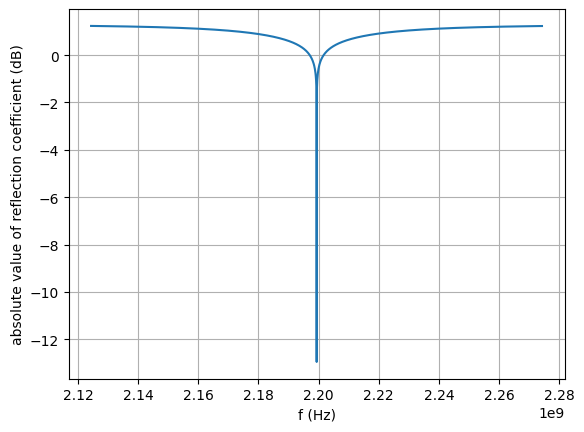

In [18]:
# g)

f = np.arange(f0 - 150e6/2, f0 + 150e6/2, 1e5)
w = f * (2*pi)
Z_in = calculate_Z_in(w)

Z0 = 50
def reflection_coefficient(Z_in):
    return np.abs((Z_in - Z0)/(Z_in + Z0))

R_in = reflection_coefficient(Z_in)
R_in_db = np.log10(20 * R_in)

fig, ax = plt.subplots()
ax.plot(f, R_in_db)
ax.set(xlabel='f (Hz)', ylabel='absolute value of reflection coefficient (dB)')
ax.grid()

if save:
    plt.savefig("R_in.png")